## **Spatial Clustering of Molecular Localizations with MIRO**


This tutorial demonstrates how to train and utilize **MIRO** for clustering point clouds from single-molecule localization microscopy.

One of **MIRO**'s standout features is its ability to train effectively with minimal data. Typically, it requires only a small set of representative clusters—on the order of a few tens. Remarkably, as you will see in this tutorial, **MIRO** can deliver outstanding results even when trained on a single cluster, making it highly efficient and versatile for a wide range of applications.

### **1. Load the dataset**


To begin, load the training data consisting of a single ellipsoidal cluster.


In [1]:
import pandas as pd

# load the training data
train_data = pd.read_csv("data/train_data.csv")

Use the code snippet below to visualize the cluster.


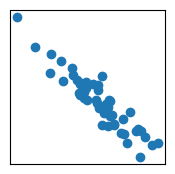

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
plt.scatter(train_data["x"], train_data["y"])
plt.xticks([])
plt.yticks([])
plt.show()

### **2. Build the training dataset**


To generalize across diverse cluster arrangements, the framework utilizes the training cluster to generate an _augmented_ dataset.

The augmentation process involves randomly applying rotations, reflections, localization dropouts/additions, and displacements to the original cluster. These transformed clusters are then randomly positioned within a field of view to create diverse training point clouds.

To further enrich the training dataset, background localizations are added to each generated point cloud, sampled from a uniform distribution across the field of view.


In [3]:
import lib

# Initialize the graph dataset builder
graph_builder = lib.CreateGraphDataset(
    train_data,  # Training data)
    dataset_size=1000,  # Total number of augmented samples to generate
    noise_point_range=(
        450,
        550,
    ),  # Range for the number of background points per sample
    cluster_count_range=(10, 20),  # Range for the number of clusters per sample
    connectivity_radius=0.2,  # Radius for defining edges in the graph
)

# Generate the augmented dataset
augmented_dataset = graph_builder()

Generating dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

Let’s take a closer look at one of the augmented training examples.

We will visualize the point cloud, represented as a _graph_, along with its corresponding ground truth labels. These labels are depicted as _displacement vectors_, pointing from each node (localization) to its respective cluster center.


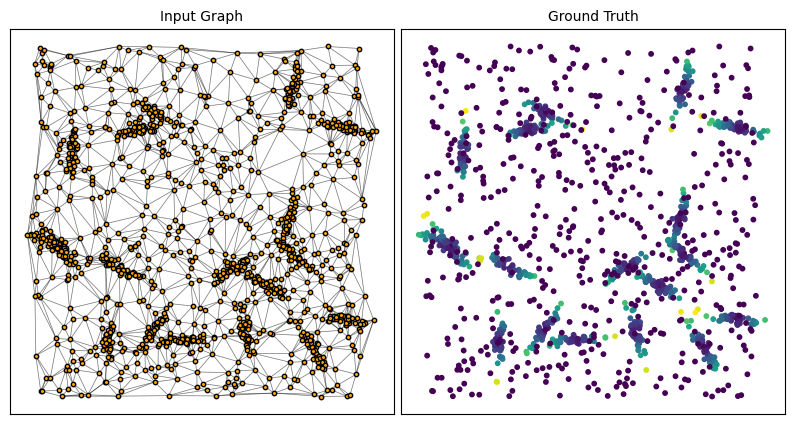

In [4]:
import numpy as np


def plot_training_data(sample_idx):
    """
    Visualizes a single augmented training example.

    Parameters:
    - sample_idx (int): Index of the sample in the augmented dataset to visualize.

    The visualization includes:
    1. The input graph representation of the point cloud.
    2. The ground truth displacement vectors, visualized as the norm of the vectors.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    data = augmented_dataset[sample_idx]

    # Plot the graph representation
    for edge in data["edge_index"].T:
        x = [data["position"][edge[0]][0], data["position"][edge[1]][0]]
        y = [data["position"][edge[0]][1], data["position"][edge[1]][1]]
        ax[0].plot(x, y, color="black", linewidth=0.5, alpha=0.3)
    ax[0].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        s=10,
        zorder=2,
        c="orange",
        edgecolors="black",
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Input Graph", fontsize=10)

    # Plot the ground truth displacement vectors
    ax[1].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        c=np.linalg.norm(data["y"], axis=1),
        s=10,
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Ground Truth", fontsize=10)

    plt.subplots_adjust(wspace=0.02)
    plt.show()


random_sample_idx = np.random.randint(0, len(augmented_dataset))
plot_training_data(random_sample_idx)

#### **3. Create the model**


Now, instantiate **MIRO**.

In [5]:
import deeplay as dl

# Initialize the MIRO clustering framework
clusterer = dl.MIRO(
    num_outputs=2,  # Number of output features (e.g., x, y displacements)
    connectivity_radius=graph_builder.connectivity_radius,  # Radius for graph connectivity (matches dataset)
)

# Configure the model backbone
clusterer.model.backbone.configure(
    num_iter=10  # Number of recurrent iterations for graph processing
)
clusterer = clusterer.create()

print(clusterer)

MIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
             

### **4. Train the model**


Set up the data loaders and configure the training parameters.

In [6]:
from torch_geometric.data import DataLoader

# Create a DataLoader for the augmented dataset
train_loader = DataLoader(
    dataset=augmented_dataset,  # The dataset to be loaded
    batch_size=4,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset at every epoch
)

# Initialize the trainer
trainer = dl.Trainer(max_epochs=30)  # Maximum number of training epochs

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Finally, train **MIRO**.

In [7]:
trainer.fit(
    clusterer,  # The MIRO model to be trained
    train_loader,  # The DataLoader providing the training data
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ RecurrentMessagePassingModel │    514 │ train │
│ 1 │ loss          │ L1Loss                       │      0 │ train │
│ 2 │ train_metrics │ MetricCollection             │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection             │      0 │ train │
│ 4 │ test_metrics  │ MetricCollection             │      0 │ train │
│ 5 │ optimizer     │ Adam                         │      0 │ train │
└───┴───────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 514                                                                                              
Non-trainable params: 0                                                                                            
Total params: 514                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 49                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


### **5. Test Model**


Once training is complete, it’s time to evaluate MIRO on a test point cloud.

Let’s begin by loading and visualizing the test point cloud.

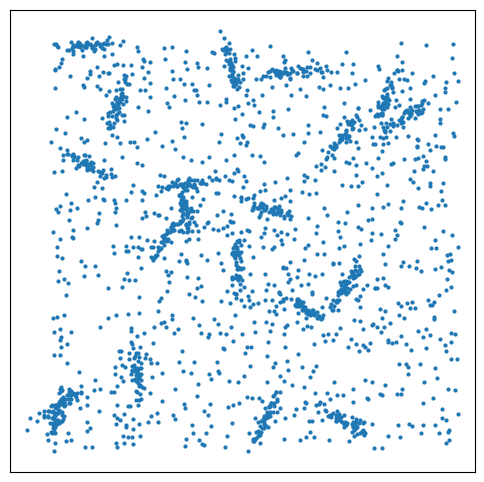

In [8]:
val_data = pd.read_csv("data/val_data.csv")

plt.figure(figsize=(6, 6))
plt.scatter(val_data["x"], val_data["y"], s=4)
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.show()

From the test point cloud, we generate its graph representation using the `compute_test_graph` function.

In [9]:
import torch
from torch_geometric.data import Data

def compute_test_graph(data, graph_builder):
    """
    Creates a graph representation of a test point cloud..

    Parameters:
    - data (pd.DataFrame): A pandas DataFrame containing the test point cloud data. 
                           It should include at least the "x" and "y" columns representing positions.
    - graph_builder (object): An instance of the graph builder class used to define graph connectivity and embeddings.

    Returns:
    - test_graph (torch_geometric.data.Data): A PyTorch Geometric Data object representing the test graph,
                                              prepared for evaluation on the MIRO model.
    """
    # Extract position data from the test dataset
    position = data[["x", "y"]].values

    # Normalize the position coordinates to the range [0, 1]
    normalized_position = (position - position.min(axis=0)) / (
        position.max(axis=0) - position.min(axis=0)
    )

    # Initialize the graph data structure
    test_graph = Data(
        position=torch.tensor(normalized_position, dtype=torch.float32),  # Node positions
        num_nodes=position.shape[0],                                     # Number of nodes
    )

    # Compute graph connectivity (edge indices and attributes) using the graph builder
    test_graph.edge_index, test_graph.edge_attr = graph_builder.compute_connectivity(
        test_graph.position
    )

    # Compute the Laplacian embedding of the graph
    test_graph = graph_builder.laplacian_embedding(test_graph)

    return test_graph.to("cuda" if torch.cuda.is_available() else "cpu")


# Create the test graph representation
val_graph = compute_test_graph(val_data, graph_builder)

Now, we can feed the test graph into **MIRO**'s `clustering` method to obtain the predicted cluster assignments. 

This method perform clustering using the DBSCAN algorithm, with **MIRO** preprocessing.

In [10]:
clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

# Perform clustering on the validation graph
clusters = clusterer.clustering(
    val_graph,                   # Input graph representing the validation point cloud
    eps=26,                      # DBSCAN epsilon parameter for neighborhood radius
    min_samples=15,              # DBSCAN minimum samples parameter for core points
    scaling=val_data[["x", "y"]].max().values  # Used to convert displacements back to the original coordinate scale
)

For comparison, we apply DBSCAN directly to the test point cloud, using parameters consistent with those reported in the [literature](https://www.nature.com/articles/s41592-022-01750-6).

In [11]:
from sklearn.cluster import DBSCAN

dbclusters = DBSCAN(eps=30, min_samples=6).fit_predict(val_data[["x", "y"]])

Finally, we visualize the test point cloud with the predicted cluster assignments from both DBSCAN, **MIRO**-enhanced DBSCAN, and the ground truth labels.

/tmp/ipykernel_13153/2356356077.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[i].scatter(


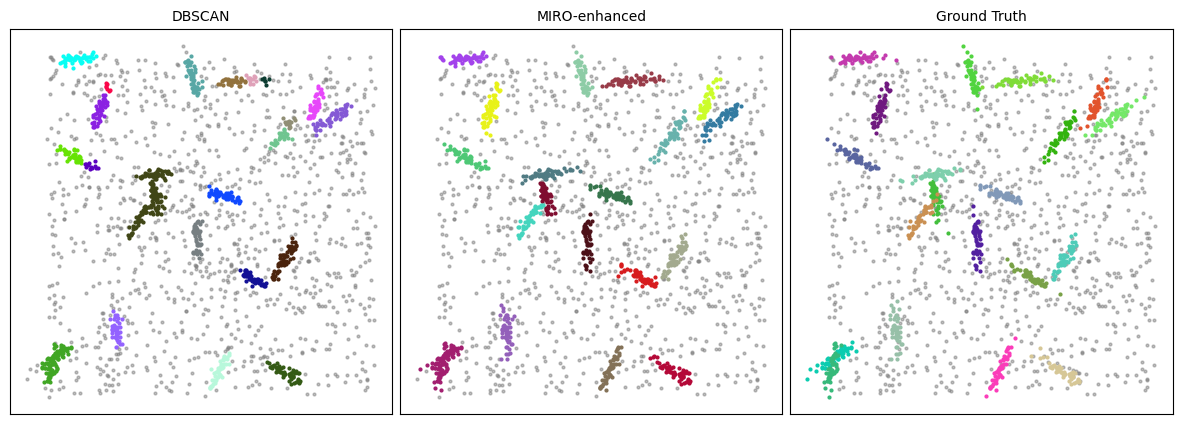

In [12]:
def plot_clustering_results(data, predicted_clusters, db_clusters):
    """
    Visualizes the clustering results across different approaches: DBSCAN, MIRO-enhanced DBSCAN, and the ground truth.

    Parameters:
    - data (pd.DataFrame): A DataFrame containing the point cloud data with columns "x", "y", and "index".
    - predicted_clusters (array-like): Cluster labels predicted by MIRO-enhanced DBSCAN.
    - db_clusters (array-like): Cluster labels predicted directly by DBSCAN.

    This function creates a side-by-side comparison of the following:
    1. Clusters identified by DBSCAN directly on the point cloud.
    2. Clusters identified by MIRO-enhanced DBSCAN.
    3. Ground truth cluster labels for the point cloud.

    The visualization distinguishes clusters with unique colors and marks background points (cluster `-1`) in gray.
    """
    # Create a figure with 3 subplots for the clustering comparisons
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Adjust indices for ground truth clusters
    data_index = data["index"] - 1

    # Titles for each subplot
    titles = ["DBSCAN", "MIRO-enhanced", "Ground Truth"]

    # Loop through each clustering method and visualize results
    for i, c in enumerate([db_clusters, predicted_clusters, data_index]):
        ax[i].set_xticks([])  # Remove x-axis ticks for a cleaner plot
        ax[i].set_yticks([])  # Remove y-axis ticks for a cleaner plot
        ax[i].set_title(titles[i], fontsize=10)  # Set title for the subplot

        # Iterate through unique cluster labels
        for u in np.unique(c):
            if u == -1:  # Background points (label -1)
                ax[i].scatter(
                    data["x"][c == u],  # x-coordinates of background points
                    data["y"][c == u],  # y-coordinates of background points
                    s=4,                # Point size
                    c="gray",           # Background color
                    alpha=0.5,          # Transparency for background points
                )
            else:  # Clustered points
                ax[i].scatter(
                    data["x"][c == u],  # x-coordinates of clustered points
                    data["y"][c == u],  # y-coordinates of clustered points
                    s=4,                # Point size
                    c=np.random.rand(3), # Random RGB color for each cluster
                )
    plt.subplots_adjust(wspace=0.02)  # Adjust spacing between subplots
    plt.show()

plot_clustering_results(val_data, clusters, dbclusters)